# 规则

双方的兵力随机投入战斗，有利一方可以预设故意降低自己的兵力投入来引诱对方战斗。

双方会不断判定小冲突机会，不过对对方数量的判定是误差的（以一个分布描述）。
弱势一方可以通过不断的有力的小战斗逆转局势，也可以通过不断回避战斗避免被消灭。
但每次回避会消耗纵深，纵深消耗完时直接失败，若为防守战则直接灭国，故AI在此时
必会决战。战斗但战斗失败则只会损失微小的纵深。

战略分散度越高发现进攻战机越多，但防守和进攻能投入的兵力越少。将领会显著增加
发现进攻战机会和投入防守进攻的兵力，但对战斗本身的表现不大。

为了经常可以造出有意义的战斗，我们可以在一个进攻战里先投一个总体骰子决定投入率，
再按这个投入率投一个二项分布骰子（那为啥不直接投个百分比骰子。。）

## 侦查模型

一次战斗机会双方实际投入战力是事先决定的

进攻方会以一个外部决定的侦查力量（一个百分比）来侦查对方的防守力量，是一个以对方数量
为n为，由侦查力量为p的二项分布。攻方知道自己在以这个值侦查，（不考虑守方故作声势）
但他只知道一次抽样结果，所以我们可以给一个均匀先验，从而以标准化似然函数可以直接
反推后验分布，攻方将看到这个后验分布做决策。


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

我们考虑一次战斗，12对10，以50%侦查率侦察到4，从而后验分布为（这里故意不计算那个标准化因子，直接以似然函数标准化得到）

In [33]:
n = np.arange(1000)
p = 0.5
likelihood = stats.binom(n,p).pmf(4)
pmf = likelihood/likelihood.sum()

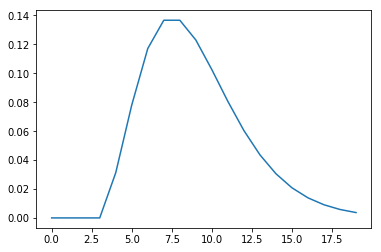

In [34]:
plt.plot(n[:20],pmf[:20])

In [35]:
mean = np.sum(n * pmf)
sd = np.sqrt(np.sum((n - mean)**2 * pmf))
mean,sd

(9.0, 3.1622776601683795)

12对10，以10%侦查到0

In [38]:
p = 0.1
likelihood = stats.binom(n,p).pmf(0)
pmf = likelihood/likelihood.sum()

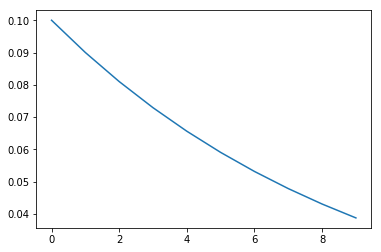

In [40]:
plt.plot(n[:10],pmf[:10])

In [41]:
mean = np.sum(n * pmf)
sd = np.sqrt(np.sum((n - mean)**2 * pmf))
mean,sd

(8.9999999999999982, 9.4868329805051363)

## 连续整合

战斗中会以较高的侦查力量继续侦查敌人数量，同时这个信息会整合之前的信息，从外部，整体来看这种连续的整合就和卡尔曼滤波一样可以增加精度
当然具体一次实现可能之前一次误导性的侦查会持续的误导后面的信息也不知道。

同时敌人损失的数量也是不知道的，但会根据战斗模型推出一个分布。

## 战斗模型

战斗模型就是一方根据自己战力投出一个骰子，以自己战力为n以战力因子和步长因子为p，决定一个杀伤数，对方损失那个杀伤数或损失完。由于那个p
对方并不知道，所以不能将这个信息本身进行整合（本来也可以以给那个p一个先验分布，如一个beta凑成共轭之类的，
不过这个信息相对后面那个信息太弱了）。

算了，就暂时假设p都是已知而且一样的，而且0.1来继续整合信息。

In [46]:
def poster(obs, p, prior=None, n=None):
    if n is None:
        n = np.arange(1000)
    if prior is None:
        prior = np.ones(n.shape[0])/n.shape[0]
    likelihood = stats.binom(n,p).pmf(obs)
    pmf = likelihood * prior
    return pmf/pmf.sum()

In [110]:
def report_pmf(pmf,n = None,verbose=True):
    if n is None:
        n = np.arange(1000)
    rv = stats.rv_discrete(values=(n,pmf))
    if verbose:
        print('mean: {} sd: {} 2.5%: {} 50%: {} 97.5%: {}'.format(rv.mean(),rv.std(),rv.ppf(0.025),rv.ppf(0.5),rv.ppf(0.975)))
    return rv.mean(),rv.std(),rv.ppf(0.025),rv.ppf(0.5),rv.ppf(0.975)
    

In [80]:
def decrease_pmf(pmf,m):
    N = pmf.shape[0]
    pmf_new = np.zeros(N)
    pmf_new[:(N-m)] = pmf[m:]
    pmf_new[0] += pmf[:m].sum()
    return pmf_new

In [81]:
decrease_pmf(np.array([0.1,0.2,0.3,0.4]),1)

array([ 0.3,  0.3,  0.4,  0. ])

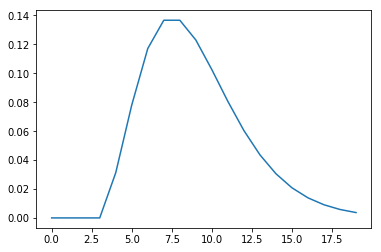

In [71]:
plt.plot(poster(4,0.5)[:20])

In [72]:
report_pmf(poster(4,0.5))

mean: 9.0 sd: 3.1622776601683795 2.5%: 4.0 50%: 8.0 97.5%: 16.0


In [55]:
stats.rv_discrete(values=(n,poster(4,0.5))).stats(moments =  'mvsk')

(array(9.0), array(10.0), array(0.9486832980505138), array(1.299999999999982))

In [56]:
d = stats.rv_discrete(values=(n,poster(4,0.5)))

In [57]:
d.ppf(0.025)

4.0

In [58]:
d.ppf(0.975)

16.0

In [59]:
d.mean()

9.0

In [60]:
d.std()

3.1622776601683795

In [113]:
def process(ally,enemy,recon_p = 0.3,battle_p = 0.1,god=True,interactive=False,trace=False,verbose=True):
    _trace = []
    if not verbose:
        print = lambda string:None
    recon_obs = stats.binom(enemy,recon_p).rvs()
    print('recon factor : {}'.format(recon_obs))
    post = poster(recon_obs,recon_p)
    mu,std,ppf1,ppf2,ppf3 = report_pmf(post,verbose=verbose)
    #print('god view: {}'.format(enemy))
    _trace.append([ally,enemy,mu])
    while ally >0 and enemy>0:
        print('battle ally : {}'.format(ally))
        if god:
            print('enemy : {}'.format(ally,enemy))
        if interactive:
            inp = input('press n to exit or press anything except n to continue')
            if inp == 'n':
                break
        ally_fire_factor = stats.binom(ally,battle_p).rvs()
        enemy_fire_factor = stats.binom(enemy,battle_p).rvs()
        ally -= enemy_fire_factor
        enemy -= ally_fire_factor
        print('ally fire factor {}'.format(ally_fire_factor))
        print('enemy fire factor {}'.format(enemy_fire_factor))
        post = poster(enemy_fire_factor,battle_p,prior = post)
        post = decrease_pmf(post, ally_fire_factor)
        mu,std,ppf1,ppf2,ppf3 =report_pmf(post,verbose=verbose)
        _trace.append([ally,enemy,mu])
    if trace:
        return _trace
    return ally,enemy

In [87]:
process(12,10)

recon factor : 4
mean: 15.66666666666666 sd: 6.2360956446232265 2.5%: 6.0 50%: 15.0 97.5%: 30.0
ally : 12 enemy : 10
enemy fire factor 2
mean: 14.429004693910379 sd: 5.703735580503933 2.5%: 5.0 50%: 14.0 97.5%: 28.0
ally : 10 enemy : 8
enemy fire factor 2
mean: 15.462957979424228 sd: 5.27055217990101 2.5%: 7.0 50%: 15.0 97.5%: 27.0
ally : 8 enemy : 8
enemy fire factor 0
mean: 11.997425967748672 sd: 4.439457859833813 2.5%: 5.0 50%: 11.0 97.5%: 22.0
ally : 8 enemy : 7
enemy fire factor 0
mean: 10.20454114189633 sd: 3.8326431472671914 2.5%: 4.0 50%: 10.0 97.5%: 19.0
ally : 8 enemy : 7
enemy fire factor 2
mean: 10.514442804157913 sd: 3.7296392294706497 2.5%: 4.0 50%: 10.0 97.5%: 19.0
ally : 6 enemy : 6
enemy fire factor 2
mean: 11.694390194646843 sd: 3.616376141458129 2.5%: 6.0 50%: 11.0 97.5%: 20.0
ally : 4 enemy : 6
enemy fire factor 1
mean: 11.469485300671025 sd: 3.3916738207914823 2.5%: 6.0 50%: 11.0 97.5%: 19.0
ally : 3 enemy : 6
enemy fire factor 0
mean: 10.365642143828357 sd: 3.0887

In [90]:
process(12,10)

recon factor : 2
mean: 9.0 sd: 4.8304589153964805 2.5%: 2.0 50%: 8.0 97.5%: 21.0
ally : 12 enemy : 10
enemy fire factor 1
mean: 9.050354537046555 sd: 4.311584316168707 2.5%: 3.0 50%: 8.0 97.5%: 19.0
ally : 11 enemy : 10
enemy fire factor 1
mean: 9.103641574128385 sd: 3.930047555488799 2.5%: 3.0 50%: 9.0 97.5%: 18.0
ally : 10 enemy : 10
enemy fire factor 1
mean: 9.149671505731947 sd: 3.633585116109429 2.5%: 4.0 50%: 9.0 97.5%: 18.0
ally : 9 enemy : 10
enemy fire factor 3
mean: 10.127943337975196 sd: 3.844076814975278 2.5%: 4.0 50%: 10.0 97.5%: 19.0
ally : 6 enemy : 8
enemy fire factor 0
mean: 6.7588448699284065 sd: 3.3804268504930515 2.5%: 1.0 50%: 6.0 97.5%: 14.0
ally : 6 enemy : 6
enemy fire factor 0
mean: 3.756401638631612 sd: 2.907154697096242 2.5%: 0.0 50%: 3.0 97.5%: 10.0
ally : 6 enemy : 4
enemy fire factor 0
mean: 2.9732997926028712 sd: 2.550286898968968 2.5%: 0.0 50%: 3.0 97.5%: 9.0
ally : 6 enemy : 4
enemy fire factor 0
mean: 1.6231985701754126 sd: 2.002821601177124 2.5%: 0.0 

(5, 0)

下面是一个剧本，玩家会遇到一些战斗，玩家要尽可能快的，以最优的比率杀伤敌人，这要求判断出一个局势是否对己方有利。从受干扰的信息中。

In [99]:
def play(ally_total=100,enemy_total=100,god=False):
    while ally_total > 0 and enemy_total > 0 :
        print('ally : {}'.format(ally_total))
        if god:
            print('enemy : {}'.format(enemy_total))
        ally = np.random.randint(ally_total)
        enemy = np.random.randint(enemy_total)
        ally_total -= ally
        enemy_total -= enemy
        ally_res,enemy_res = process(ally,enemy,interactive=True,god=god)
        ally_total += ally_res
        enemy_total += enemy_res
    return ally_total,enemy_total

In [100]:
play()

ally : 100
recon factor : 6
mean: 22.333333333333325 sd: 7.378647873726208 2.5%: 11.0 50%: 21.0 97.5%: 39.0
battle ally : 90
press n to exit or press anything except n to continue
ally fire factor 11
enemy fire factor 4
mean: 15.04169435172027 sd: 7.152216917865837 2.5%: 3.0 50%: 14.0 97.5%: 31.0
battle ally : 86
press n to exit or press anything except n to continue
ally fire factor 13
enemy fire factor 0
mean: 1.3997112193313543 sd: 3.0218264890244253 2.5%: 0.0 50%: 0.0 97.5%: 11.0
ally : 96
recon factor : 23
mean: 78.99999999999982 sd: 13.66260102127931 2.5%: 55.0 50%: 78.0 97.5%: 108.0
battle ally : 61
press n to exit or press anything except n to continue
ally fire factor 8
enemy fire factor 4
mean: 63.087159176635424 sd: 11.366256889883083 2.5%: 43.0 50%: 62.0 97.5%: 87.0
battle ally : 57
press n to exit or press anything except n to continue
ally fire factor 6
enemy fire factor 3
mean: 51.06407619239515 sd: 9.7296030465669 2.5%: 34.0 50%: 50.0 97.5%: 72.0
battle ally : 54
press 

(74, 0)

In [114]:
trace=process(100,100,trace=True,verbose=False)

In [116]:
trace[:5]

[[100, 100, 112.33333333333361],
 [90, 89, 98.645294867157105],
 [80, 81, 90.800568063227217],
 [72, 74, 81.924797923726317],
 [67, 67, 69.98724497196595]]

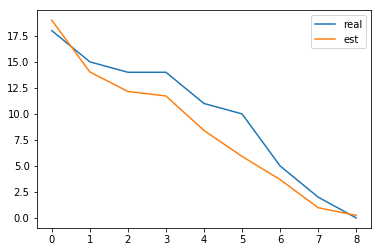

In [122]:
trace = np.array(trace)
plt.plot(trace[:,1],label='real')
plt.plot(trace[:,2],label='est')
plt.legend()
plt.show()

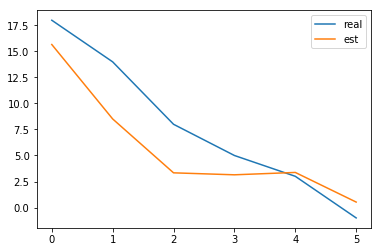

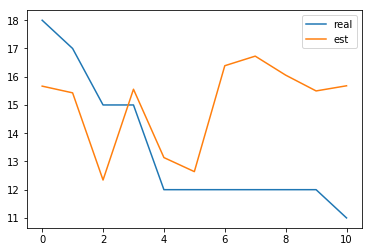

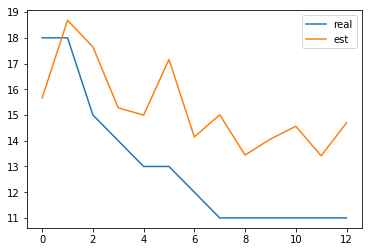

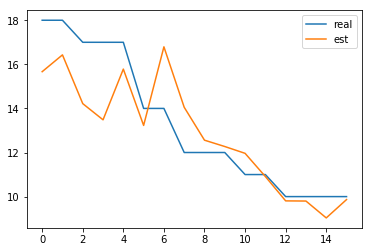

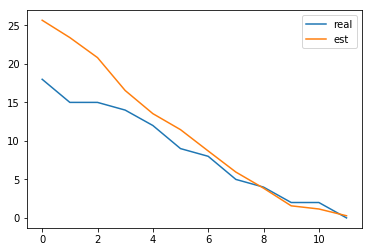

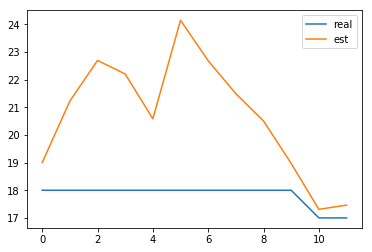

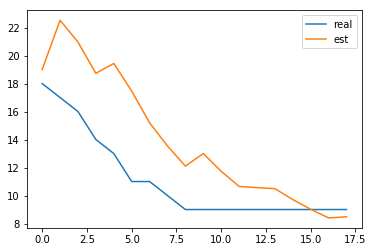

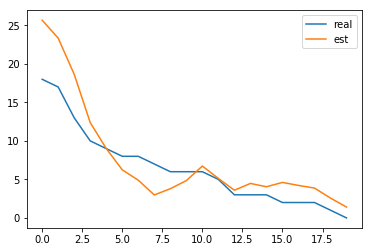

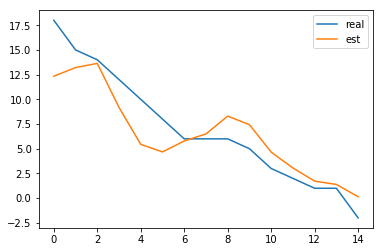

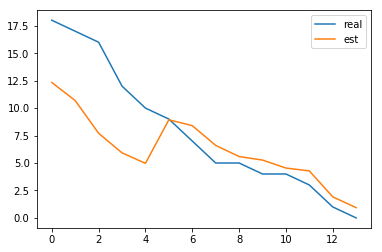

In [123]:
for i in range(10):
    trace=process(20,18,trace=True,verbose=False)
    trace = np.array(trace)
    plt.plot(trace[:,1],label='real')
    plt.plot(trace[:,2],label='est')
    plt.legend()
    plt.show()